# Waveform Selection

Optimized PMT waveform selection script.

In [1]:
# General Imports

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import uproot3
import pandas

from matplotlib.colors import LogNorm
import scipy.signal
from numpy.fft import fft, ifft, ifftshift
from matplotlib.colors import LogNorm

In [2]:
# Plotting style file

plt.style.use("LateLightStyle.mplstyle")

In [620]:
#PATH = 'data/late_light/'
#FNAME = 'prod_extbnb_optfilter_mcc9.0_reco2_lite_C2'
PATH = 'data/late_light_timedep/'
FNAME = 'prod_extunbiased_swizzle_crt_inclusive_v6_v6a_goodruns_mcc9_run3'
wffile = uproot3.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]

In [621]:
#wfdf = wffile['wf_26'].pandas.df(flatten=False)

print(wffile.keys())
wfdf = wffile.array('wf_17')

print(len(wfdf))

[b'run', b'subrun', b'event', b'ped_mean_v', b'ped_rms_v', b'max_adc_v', b'min_adc_v', b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31', b'wfsum']
43814


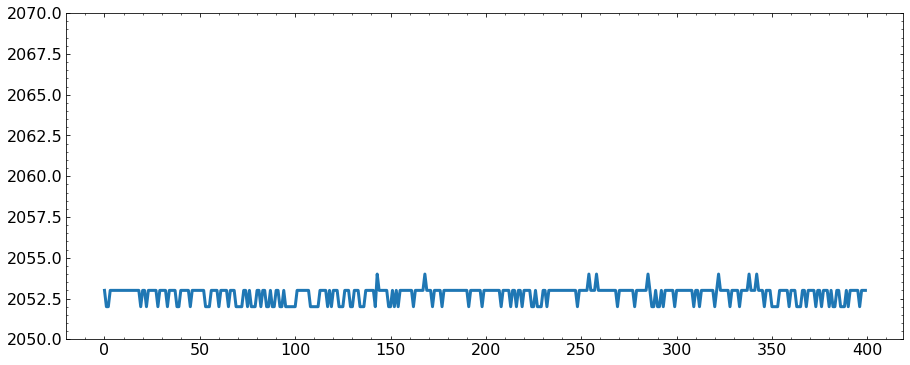

2054


In [633]:
# quickly examine the waveforms of wf_17

fig = plt.figure(figsize=(15,6))
plt.plot(wfdf[0][0:400])
plt.ylim([2050,2070])
plt.show()


print(max(wfdf[0]))

In [622]:
# Function for calculating the baseline and rms
# TODO: Consider vectorizing all these functions

def baseline(data, init):
    baseline = np.mean(data[0:init])
    #rms = np.sqrt(np.sum([(i-baseline)**2 for i in data])/len(data))
    # Vectorized version
    rms = np.sqrt(np.sum(data-baseline)**2/len(data))
    return baseline, rms

# Reparse SPE events with new parameter

def SPE_tail(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    i = 0
    while i < len(data[init:]):
        cache = []
        if 30>data[i]-baseline>10:
            if len(data[i-20:i-1])!=0 and abs(rms)<=5 and -rms<np.max([j-baseline for j in data[i-10:i-1]])<rms:
                cache.extend(data[i-10:i-1])
                while data[i]-baseline>10 and i in range(len(data[init:])):
                    cache.append(data[i])
                    i += 1
                # end of the waveform here is defined as i+4 by observation
                if max(data[i+4:i+4+after]-baseline) <= 4*rms and len(data[i+4:i+4+after])==after:
                    cache.extend(data[i+1:i+4+after])
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0 and max(cache)-baseline<30:
            waveform.append(cache-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
        else:
            pass
        i += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

# Simple function for taking average of every time bin

# for a completely rectangular data array
'''
def mean_fit(data_arr):
    mean_wf = []
    for i in range(len(data_arr[0])):
        data_pts = [j for j in data_arr[:][i]]
        mean_wf.append(np.mean(data_pts))
    return mean_wf
'''

# Given the non-uniformity of the current waveforms, we have the following avg function: 
def mean_fit(data_arr):
    mean_wf = []
    i = 0
    while True:
        try:
            # Think of a way to take the average of less and less waveforms
            mean_wf.append(np.mean([data_arr[j][i] for j in range(len(data_arr))]))
        # Try to find the specific error instead of having only except
        except:
            break
        i += 1
    return mean_wf

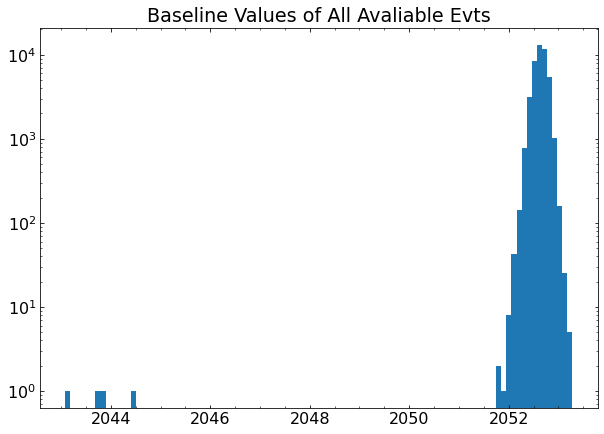

In [623]:
# Calculate baseline and RMS for each evt separately

# Index number of the last event included
evtn = -1

baseline_li = []

# Use the first 100 data points as baseline
init_time = 100

for i in wfdf[0:evtn]:
    baseline_li.append(baseline(i,init_time))

baseline_arr = np.asarray(baseline_li)

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(baseline_arr[:,0], bins=100)
ax.set_title("Baseline Values of All Avaliable Evts")
plt.show()

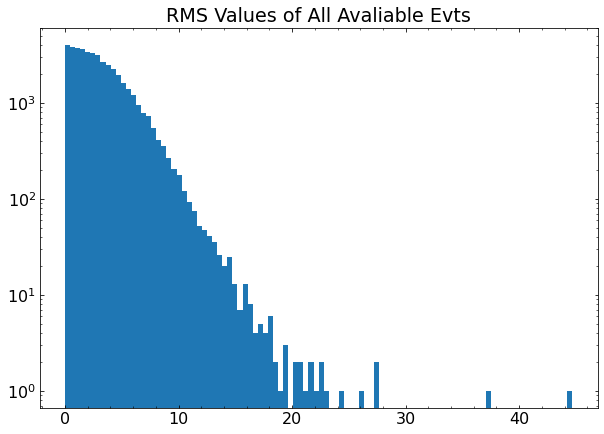

In [624]:
# rms value of all events
fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(baseline_arr[:,1], bins=100)
ax.set_title("RMS Values of All Avaliable Evts")
plt.show()

In [625]:
# Exclude the evts with bad baselines (take the middle 2 sigma of the baseline distribution)
# First simply exclude bad baselines with hard parameter

bsline_rough = [list(i) for i in baseline_arr if 2000<i[0]<2200]
bsline_rough = np.asarray(bsline_rough)

print(bsline_rough[:,0])

bslin_mean = baseline(bsline_rough[:,0], len(bsline_rough[:,0]))
print(bslin_mean)

# try list comprehension
# Not super necessary for now
'''
bslin_good = [list(i) for i in baseline_arr if bslin_mean[0]-bslin_mean[1]*0.5<i[0]<bslin_mean[0]+bslin_mean[1]*0.5]
bslin_good = np.asarray(bslin_good)

print(bslin_good)

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
ax.hist(bslin_good, bins=100)
ax.set_title("Good Baseline Evts")
plt.show()
'''

[2052.66 2052.71 2052.76 ... 2053.15 2052.9  2052.69]
(2052.6342044598637, 3.28304063004294e-11)


'\nbslin_good = [list(i) for i in baseline_arr if bslin_mean[0]-bslin_mean[1]*0.5<i[0]<bslin_mean[0]+bslin_mean[1]*0.5]\nbslin_good = np.asarray(bslin_good)\n\nprint(bslin_good)\n\nfig, ax = plt.subplots(figsize =(10, 7))\nax.set_yscale("log")\nax.hist(bslin_good, bins=100)\nax.set_title("Good Baseline Evts")\nplt.show()\n'

In [626]:
'''
SPEtail_arr = []

#for i in range(len(wfdf[0:evtn])):
# only sample some good baseline events
for i in range(len(wfdf[0:evtn])):
    if baseline_arr[i][1] <= 200:
        SPEtail_arr.append(np.asarray(SPE_tail(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time, 200)))
    else:
        pass
'''

'\nSPEtail_arr = []\n\n#for i in range(len(wfdf[0:evtn])):\n# only sample some good baseline events\nfor i in range(len(wfdf[0:evtn])):\n    if baseline_arr[i][1] <= 200:\n        SPEtail_arr.append(np.asarray(SPE_tail(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time, 200)))\n    else:\n        pass\n'

In [627]:
SPEtail_arr = np.empty(6, dtype=object)

for i in range(len(wfdf[0:evtn])):
    spe_temp = [SPE_tail(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time, 200)]
    if spe_temp[0] != "N":
        for j in range(len(spe_temp)):
            for l in range(len(spe_temp[j][0])):
                SPEtail_arr = np.vstack((SPEtail_arr, np.asarray([spe_temp[j][k][l] for k in range(len(spe_temp[j]))])))
    else:
        pass

SPEtail_arr = SPEtail_arr[1:]

TypeError: 'NoneType' object is not subscriptable

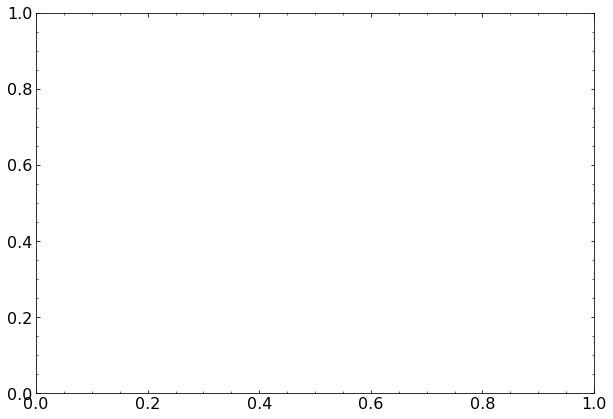

In [628]:
# Take a look at the raw SPE selection

a = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_arr)):
    if abs(max(SPEtail_arr[i][0][-30:-1])) < SPEtail_arr[i][5]:
        #ax.plot(SPEtail_arr[i][0][k], color="peru", linestyle="none", marker=".")
        #SPEtail_selected.append(SPEtail_arr[i][0][k])
        ax.plot(SPEtail_arr[i][0], color="peru", linewidth=0.5)
        a += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()

print(f"SPE detected {a}")

In [ ]:
# Take a look at the raw SPE selection
a = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_arr)):
    ax.plot(SPEtail_arr[i][0], color="peru", linewidth=0.5)
    a += 1

ax.set_title("Waveforms")
plt.show()

print(f"SPE detected {a}")

In [ ]:
# Plot all waveforms found with good baseline and rms
# IMPORTANT: At the moment this is obselete

#SPEtail_good = [i for i in SPEtail_arr if bslin_mean[0]-bslin_mean[1]*1e11<i[4]<bslin_mean[0]+bslin_mean[1]*1e11 and abs(i[5])<5]
#SPEtail_good = np.asarray(SPEtail_good)
SPEtail_good = SPEtail_arr

SPEtail_selected = []

a = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_good)):
    if abs(max(SPEtail_good[i][0][-30:-1])) < SPEtail_good[i][5]:
        #ax.plot(SPEtail_good[i][0][k], color="peru", linestyle="none", marker=".")
        SPEtail_selected.append(SPEtail_good[i][0])
        ax.plot(SPEtail_good[i][0], color="peru", linewidth=0.5)
        a += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()

print(f"SPE detected {a}")

In [ ]:
# Align all the waveforms and exclude ones with outlier beginnings

SPEtail_mod = []

#for i in SPEtail_selected:
for i in SPEtail_arr:
    if max(i[0][:7])<=2.5:
        bslin_temp = np.mean(i[0][:7])
        SPEtail_mod.append(i[0]-bslin_temp)
    else:
        pass

b = 0

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_mod)):
    ax.plot(SPEtail_mod[i], color="peru", linewidth=0.5)
    b += 1
#ax.set_xlim([0,100])
ax.set_title("Waveform")
plt.show()
print(f"SPE selected {b}")

In [ ]:
# Create a linear fit for Amplitude vs Area

# Manually exclude clear outliers before fitting

SPEtail_mod_area = [sum(i[0:25]) for i in SPEtail_mod]
SPEtail_mod_amp = [max(i[0:25]) for i in SPEtail_mod]

SPEtail_mod_amp = [SPEtail_mod_amp[i] for i in range(len(SPEtail_mod_amp)) if 0<SPEtail_mod_area[i]<190]
SPEtail_mod_area = [i for i in SPEtail_mod_area if 0<i<190]

amplinfit = np.poly1d(np.polyfit(SPEtail_mod_area,SPEtail_mod_amp,1))

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEtail_mod_area, SPEtail_mod_amp, linestyle="none", marker=".")
ax.plot(SPEtail_mod_area, [amplinfit(i) for i in SPEtail_mod_area])
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

In [ ]:
# Exlude outlier waveforms based on the amplitude vs area fit

SPEtail_modfit = []
SPEtail_modfit_area = []
SPEtail_modfit_amp = []

for i in range(len(SPEtail_mod_amp)):
    if abs(SPEtail_mod_amp[i]-amplinfit(SPEtail_mod_area[i])) < 3:
        SPEtail_modfit.append(SPEtail_mod[i])
        SPEtail_modfit_area.append(SPEtail_mod_area[i])
        SPEtail_modfit_amp.append(SPEtail_mod_amp[i])

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(SPEtail_modfit_area, SPEtail_modfit_amp, linestyle="none", marker=".")
ax.plot(SPEtail_modfit_area, [amplinfit(i) for i in SPEtail_modfit_area])
ax.set_title("Amplitude vs Area")
ax.set_xlabel("Area")
ax.set_ylabel("Amplitude")
plt.show()

In [ ]:
# Afterpulse area distribution

aftersum = [sum(i[30:]) for i in SPEtail_modfit]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(aftersum, bins=500)
ax.set_xlabel("Area")
plt.show()

In [ ]:
# See the waveform after this cut

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPEtail_modfit)):
    ax.plot(SPEtail_modfit[i], color="peru", linewidth=0.5)
#ax.plot(fit_mean_tail)
#ax.set_xlim([0,20])
ax.set_title("Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.show()

In [ ]:
# Exclude waveforms with bad afterpulses and do some final cleanup

#afteravg, afterrms = baseline(aftersum, len(aftersum))
afteravg = np.mean(aftersum)
afterrms = np.std(aftersum)

print(afterrms)

SPE_clean = []

# Right now the SPE selection seems to be largely dominated by this step with an aribitrary value upper limit
for i in range(len(SPEtail_modfit)):
    #if afteravg-afterrms < aftersum[i] < afteravg+afterrms and max(abs(SPEtail_modfit[i][20:]))<8:
    if afteravg-afterrms < aftersum[i] < afteravg+afterrms and max(SPEtail_modfit[i][20:])<2.5:
        SPE_clean.append(SPEtail_modfit[i])
    else:
        pass

SPE_clean = np.array(SPE_clean)

print(len(SPE_clean))

In [ ]:
#fit_mean_tail= mean_fit(SPE_clean)

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_clean)):
    ax.plot(SPE_clean[i], color="peru", linewidth=0.5)
#ax.plot(fit_mean_tail)
#ax.set_xlim([0,20])
ax.set_title("Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.show()

In [ ]:
# realign the SPE waveforms

for i in range(len(SPE_clean)):
    #SPE_clean[i] = SPE_clean[i]-min(SPE_clean[i])
    SPE_clean[i] = SPE_clean[i]-np.median(SPE_clean[i])

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(SPE_clean)):
    ax.plot(SPE_clean[i], color="peru", linewidth=0.5)
#ax.plot(fit_mean_tail)
#ax.set_xlim([0,20])
ax.set_title("Waveform")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.show()

In [617]:
run3wf_17SPE = SPE_clean

#%store run1SPE05_clean

In [619]:
np.savetxt("data/run3_wf/run3wf_17SPE.txt", run3wf_16SPE, fmt='%s')

### Detecting Muon signals

In [73]:
PATH = 'data/late_light_timedep/'
FNAME = 'prod_extbnb_optfilter_mcc9.0_reco2_lite_C1'
wffile = uproot3.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]
wfdf = wffile.array('wf_31')

In [74]:
# Using similar methods as detecting SPE for detecting muons
# Assume 1 PE = 20 ADU

# Some global variables for checking different cuts
maxprepul = []
maxafterpul = []
maxpeak = []
peaktime = []
arvtime = []

def muon(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    # Skip the initial ticks
    k = init
    while k < len(data)-1:
        cache = []
        #if 2000>data[k]-baseline>100:
        # Modify the lower limit to take out smaller magnitude waveforms
        if 1900>data[k]-baseline>300:
            if len(data[k-20:k-1])!=0 and abs(rms) <= 150:
                maxprepul.append(np.max([j-baseline for j in data[k-20:k-1]]))
            else:
                pass
            if len(data[k-20:k-1])!=0 and -rms<np.max([j-baseline for j in data[k-20:k-1]])<rms and abs(rms)<=400:
                cache.extend(data[k-20:k-1])
                #while 2000>data[k]-baseline>100 and i in range(len(data[init:])):
                # Modify the lower limit to take out smaller magnitude waveforms
                while 1900>data[k]-baseline>300 and k in range(len(data)-1):
                    cache.append(data[k])
                    k += 1
                # Changed the estimated afterpulse length
                # This might be excessive
                cache.extend(data[k+1:k+20])
                # Move the tick
                k += 19
            # end of the waveform here is defined as i+20 by observation
                # Record the amplitude of the main pulse and the amplitude of the afterpulse
                if len(data[k+1:k+1+after])==after:
                    maxpeak.append(np.max(cache)-baseline)
                    maxafterpul.append(np.max(data[k+1:k+1+after])-baseline)
                else:
                    pass
                # TODO: double check the afterpulse selection conditions, it might be too long
                #if np.max(data[i+20:i+20+after]-baseline) <= 10*rms and np.max(data[i:i+20]-baseline) < 2000:
                #if np.max(data[i+20:i+20+after]-baseline)/np.max(cache) <= 0.2 and np.max(data[i:i+20]-baseline) < 2000 and len(data[i+20:i+20+after])==after:
                if len(data[k+1:k+1+after])==after and np.max(data[k+1:k+1+after]-baseline)/np.max(cache-baseline) <= 0.3 and np.max(data[k-40:k+40]-baseline) < 1900:
                    #print(np.max(data[i+15:i+20+after]-baseline))
                    #print(np.max(cache))
                    cache.extend(data[k+1:k+1+after])
                    # Move the tick forward
                    k += after+1
                    #break
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0:
            waveform.append(list(cache)-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
            peaktime.append(cache.index(max(cache)))
            arvtime.append(cache.index(max(cache))+k)
        else:
            pass
        k += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

In [75]:
# Acquiring raw muon waveforms

muon_arr = np.empty(6, dtype=object)

for i in range(len(wfdf[0:evtn])):
    m_temp = [muon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time,200)]
    #m_temp = [muon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],500,200)]
    if m_temp[0] != "N":
        for j in range(len(m_temp)):
            for l in range(len(m_temp[j][0])):
                muon_arr = np.vstack((muon_arr, np.asarray([m_temp[j][k][l] for k in range(len(m_temp[j]))])))
    else:
        pass

muon_arr = muon_arr[1:]

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


IndexError: index 24034 is out of bounds for axis 0 with size 24034

In [76]:
#TODO: afterpulse distribution, peak-afterpulse amplitude ratio distribution, arrival time distribution;
# verify other selection schemes

muon_arr = muon_arr[1:]

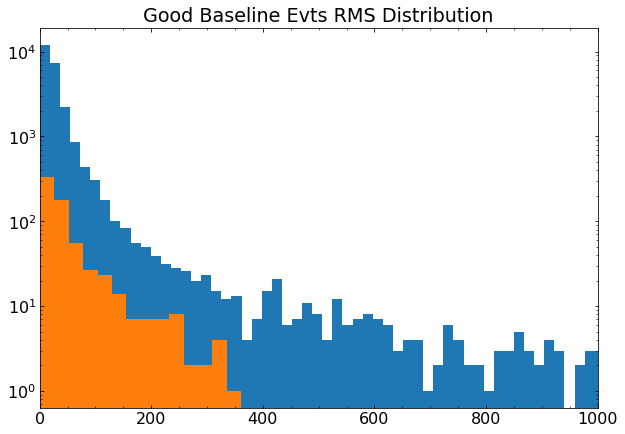

In [77]:
# Histograms of the relevant parameter distributions and the cuts I made

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_yscale("log")
#ax.hist(bslin_good[:,0], bins=np.linspace(0,50,100))
ax.hist(baseline_arr[:,1], bins=1000)
ax.hist(muon_arr[:, 5], bins=14)
ax.set_title("Good Baseline Evts RMS Distribution")
ax.set_xlim([0,1000])
plt.show()

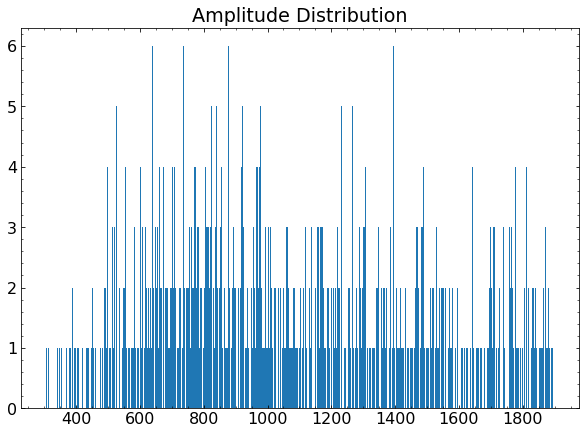

In [78]:
# Amplitude distribution

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(muon_arr[:,1], bins=500)
ax.set_title("Amplitude Distribution")
#ax.set_xlim(0, 250)
ax.minorticks_on()
plt.show()

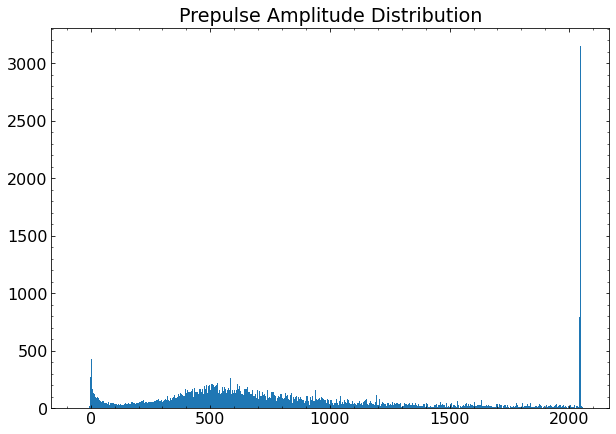

In [79]:
# TODO: generate avg prepulse & afterpulse data for each wf


# Distribution of prepulse

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(maxprepul, bins=500)
ax.set_title("Prepulse Amplitude Distribution")
plt.show()

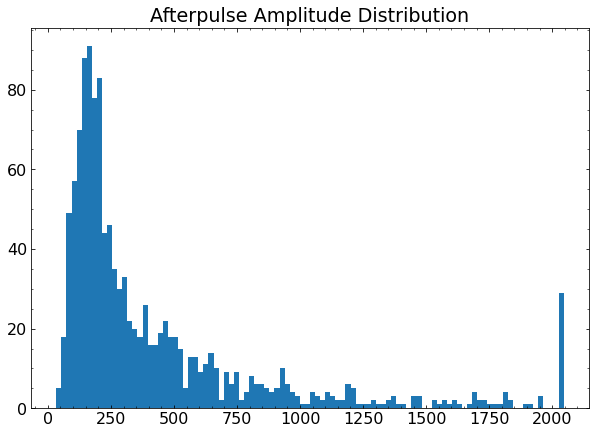

In [80]:
# Distribution of afterpulse

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(maxafterpul, bins=100)
ax.set_title("Afterpulse Amplitude Distribution")
plt.show()

In [81]:
print(len(muon_arr[:,1]))

667


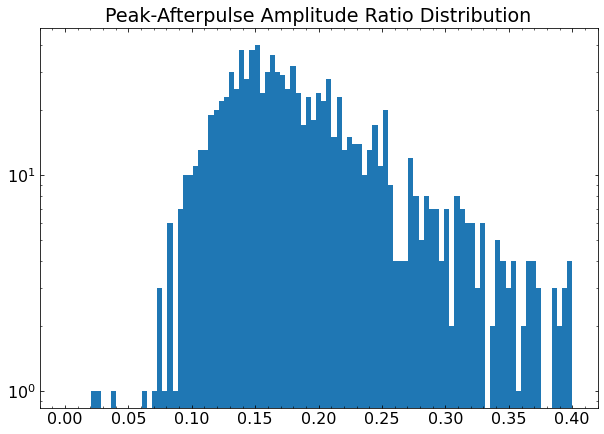

In [82]:
# Peak-Afterpulse amplitude ratio distribution

maxpeak = np.array(maxpeak)
maxafterpul = np.array(maxafterpul)

# Distribution of afterpulse

fig, ax = plt.subplots(figsize=(10, 7))
#ax.hist(maxpeak/maxafterpul)
ax.hist(maxafterpul/maxpeak, bins=np.linspace(0,0.4,100))
#ax.hist(maxafterpul/maxpeak, bins=100)
ax.set_title("Peak-Afterpulse Amplitude Ratio Distribution")
#ax.set_xlim(-2, 5)
plt.yscale("log")
plt.show()

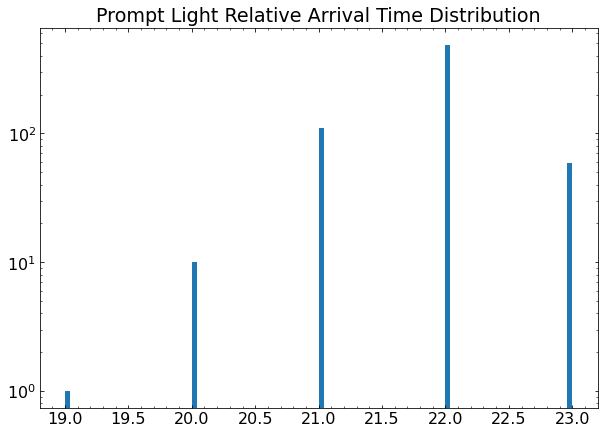

In [83]:
# Prompt light relative arrival time distribution
# (arrival time of the promopt light in the 200 tick range of each waveform)

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(peaktime, bins=100)
ax.set_title("Prompt Light Relative Arrival Time Distribution")
plt.yscale("log")
plt.show()

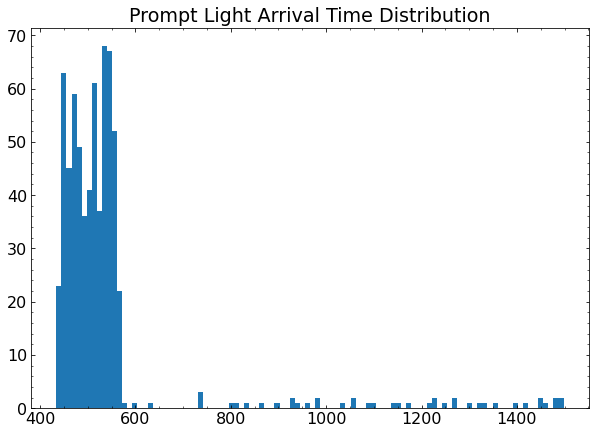

In [84]:
# Prompt light arrival time distribution
# (arrival time of the prompt light in each event)

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(arvtime, bins=100)
ax.set_title("Prompt Light Arrival Time Distribution")
#plt.yscale("log")
plt.show()

In [85]:
# Filter out waveforms from the first 400 time ticks, then check the response function
# Restrain the prompt light arrival time in each waveform too



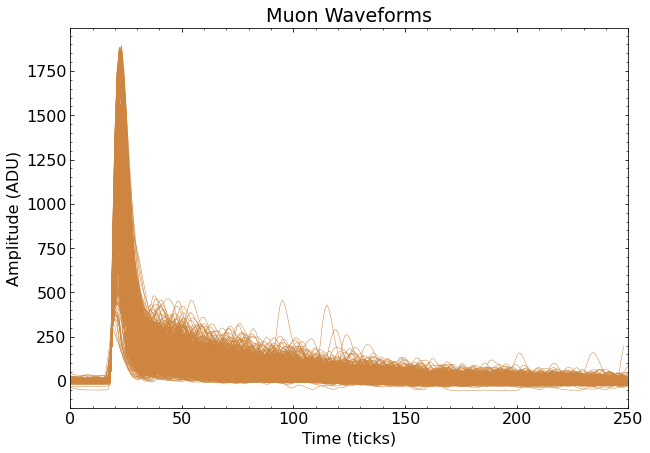

Amount of Muon waveforms selected 667


In [86]:
# TODO: A suspision: There are pulses that have a much later prompt light arrvial time
# MUST examine the muon selection function 

# Overlaying all the waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(muon_arr)):
    ax.plot(muon_arr[i][0], color="peru", linewidth=0.5)
#ax.plot(muon_arr[880][0], color="peru", linewidth=0.5)
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
ax.set_xlim(0,250)
plt.show()

print(f"Amount of Muon waveforms selected {len(muon_arr)}")

In [87]:
# Adjust waveform baselines
# Consider aligning prepulse vs using median

for i in range(len(muon_arr)):
    muon_arr[i][0] = muon_arr[i][0]-min(muon_arr[i][0][:15])
    #muon_arr[i][0] = muon_arr[i][0]-np.median(muon_arr[i][0])

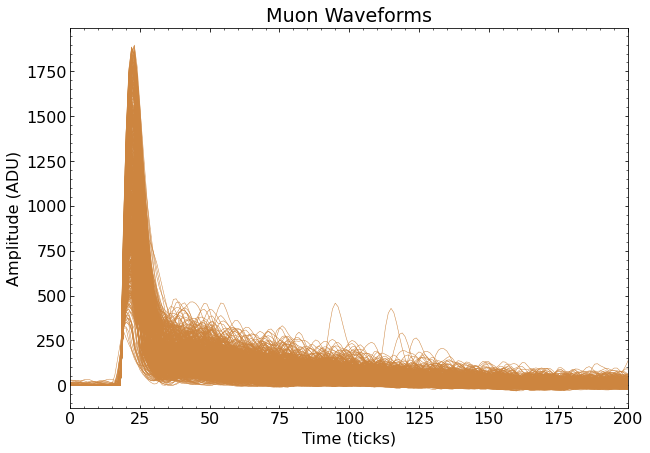

Amount of Muon waveforms selected 667


In [88]:
# TODO: A clear problem with zero points
# Plot the compiled waveforms

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(muon_arr)):
    ax.plot(muon_arr[i][0], color="peru", linewidth=0.5)
#ax.plot(muon_arr[0][0], color="peru")
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
ax.set_xlim(0,200)
plt.show()

print(f"Amount of Muon waveforms selected {len(muon_arr)}")

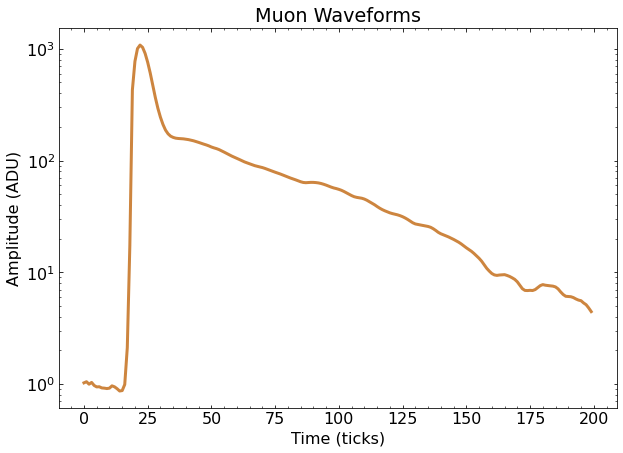

In [89]:
# Generate the average of each time bin for characterizing the noise later

muon_tavg = np.array([np.mean([i[0][j] for i in muon_arr]) for j in range(200)])

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(muon_tavg, color="peru")
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.yscale("log")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(0,200)
plt.show()

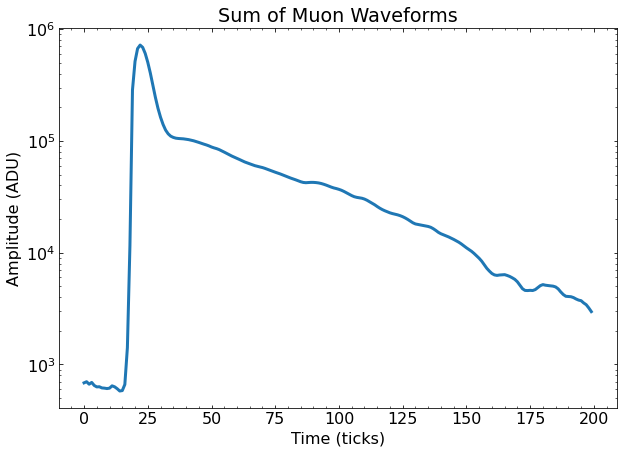

In [96]:
# Sum all waveforms, produce a rough response function
# Since the length of the kernel is 200 ticks, the response function length will also be 200 ticks

res_fun = np.zeros(shape=(200,), dtype=object)

fig, ax = plt.subplots(figsize =(10, 7))
#fig, ax = plt.subplots(figsize =(5, 7))
for i in muon_arr:
    for j in range(200):
        res_fun[j] += i[0][j]
ax.plot(res_fun)
ax.set_title("Sum of Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.yscale("log")
#ax.set_ylim(20e6-100, 20e6+100)
#ax.set_xlim(0,50)
plt.show()

In [91]:
#%store

##### Manually run this script multiple times to generate and store SPE and Muon waveforms for every PMTs

In [92]:
# Export selected muon waveforms

%store muon_arr res_fun muon_tavg

Stored 'muon_arr' (ndarray)
Stored 'res_fun' (ndarray)
Stored 'muon_tavg' (ndarray)


In [93]:
#TODO: Manually generate and store all SPE and muon waveforms

SPE31_clean = SPE_clean
muon31_arr = muon_arr
res31_fun = res_fun
muon31_tavg = muon_tavg

%store SPE31_clean muon31_arr res31_fun muon31_tavg

Stored 'SPE31_clean' (ndarray)
Stored 'muon31_arr' (ndarray)
Stored 'res31_fun' (ndarray)
Stored 'muon31_tavg' (ndarray)


In [94]:
%store -r SPE28_clean

print(len(SPE28_clean))

66529


### Empty Background Selection

In [ ]:
# Notes on ideas:
# DO NOT go through waveform selection process, simply sample a bunch of 192 time tick segments without muon randomly
# In addition to checking there's no muons, also only take the initial time span (to ensure randomness)

def nomuon(data, baseline, rms, init, wlen):
    waveform = []
    if abs(rms)<=50 and 45>max(data[0:wlen]-baseline)>-45 and min(data[0:wlen]-baseline)>(-rms) and len(data[0:wlen])==wlen:
        waveform = data[0:0+wlen]-baseline
        return waveform
    else:
        return waveform

In [ ]:
# Acquiring empty backgrounds
# The time window of backgrounds will 200 ticks

nomuon_arr = []

for i in range(len(wfdf[0:evtn])):
    nomuon_cache = nomuon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],600,200)
    if len(nomuon_cache) != 0:
        for i in range(len(nomuon_cache)):
            nomuon_arr.append(nomuon_cache[i])
    else:
        pass

nomuon_arr = np.array(nomuon_arr)

In [ ]:
# Re-adjust the waveform baseline

for i in range(len(nomuon_arr)):
    nomuon_arr[i] = nomuon_arr[i]-np.median(nomuon_arr[i])

In [ ]:
# Overlay all the selected waveforms
# Why do the signals generally increase at the end?
# Idea: add some selection area padding
# What will happen with different cuts?

fig, ax = plt.subplots(figsize =(20, 7))
for i in nomuon_arr:
    ax.plot(i, color="peru", linewidth=0.5)
ax.set_title("Background Signal")
#plt.yscale("log")
#ax.set_ylim(-10, 40)
#ax.set_xlim(175,200)
plt.show()

In [ ]:
# Check out some distributions

# Amplitude distribution
nomuon_amp = [i[np.where(abs(i)==max(abs(i)))[0][0]] for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_amp, bins=100)
ax.set_title("Background Signal Amplitude Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

# Area Distribution
nomuon_area = [sum(i) for i in nomuon_arr]

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nomuon_area, bins=100)
ax.set_title("Background Signal Area Distribution")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

In [ ]:
# Generate response function

# TODO: Consider not including bkg subtraction in presentation
# Observation: the first 400 ticks may not be useful
# Does this discredit the baseline calculation?
# There's no muons in the 1500 ticks, but after that there's muons in every evts, does this have sth to do with triggering?

nomuon_res = [sum([nomuon_arr[j][i] for j in range(len(nomuon_arr))]) for i in range(len(nomuon_arr[0]))]

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(nomuon_res)
ax.set_title("Background Signal Raw Response Function")
#plt.yscale("log")
#ax.set_ylim(-1000, 150000)
#ax.set_xlim(0,50)
plt.show()

In [ ]:
%store nomuon_arr nomuon_res